In [1]:
import torch
import torch.nn as nn 
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import math

Data Pre-Processing

In [2]:
sp500_df = pd.read_csv('./data/sp500_2y.csv')
del sp500_df['Adj Close']
sp500_df=sp500_df[['Date', 'Open', 'Close', 'High', 'Low', 'Ratio1', 'Ratio2', 'Dividends', 'Volume', 'Name', 'trend_tmr_up']]
sp500_df.head(3)

,Date,Open,Close,High,Low,Ratio1,Ratio2,Dividends,Volume,Name,trend_tmr_up
0,2020-02-19,78.915603,79.808334,80.042618,78.915603,0.396060,0.792120,0.0,93984000.0,AAPL,False
1,2020-02-20,79.564202,78.989594,80.062354,78.474177,0.505435,-0.361804,0.0,100566000.0,AAPL,False
2,2020-02-21,78.575295,77.201668,79.026598,76.572812,0.536179,-0.559799,0.0,129554000.0,AAPL,False


In [3]:
#data_all = sp500_df[['Open', 'Close', 'High', 'Low', 'Ratio1', 'Ratio2', 'Dividends', 'Volume', 'trend_tmr_up']].to_numpy()
data_all = sp500_df[['Ratio1', 'Ratio2', 'Dividends', 'Volume', 'trend_tmr_up']].to_numpy()
train_size = 162500
valid_size = 40500
test_size = len(sp500_df)-train_size-valid_size
scaler = MinMaxScaler(feature_range=(-1, 1))

train_valid_set, test_set = data.random_split(data_all, [train_size+valid_size, test_size])

train_valid_x, train_valid_y = train_valid_set[:][:, 0:-1], train_valid_set[:][:, -1]
test_x, test_y = test_set[:][:, 0:-1], test_set[:][:, -1]

train_valid_x = scaler.fit_transform(train_valid_x)
test_x = scaler.transform(test_x)

train_valid_x = torch.from_numpy(train_valid_x.astype(np.float32)).to(torch.float32)
train_valid_y = torch.from_numpy(train_valid_y.astype(np.int8)).to(torch.int8)
test_x = torch.from_numpy(test_x.astype(np.float32)).to(torch.float32)
test_y = torch.from_numpy(test_y.astype(np.int8)).to(torch.int8)

train_valid_data = TensorDataset(train_valid_x, train_valid_y.reshape(-1,1))
test_data = TensorDataset(test_x, test_y.reshape(-1,1))

train_data, valid_data = data.random_split(train_valid_data, [train_size, valid_size])

print(f'train size is {len(train_data)}')
print(f'valid size is {len(valid_data)}')
print(f'test size is {len(test_data)}')

batch_size = 100
train_load = DataLoader(train_data, batch_size, shuffle=True)
valid_load = DataLoader(valid_data, batch_size, shuffle=True)
test_load = DataLoader(test_data, batch_size, shuffle=True)

train size is 162500
valid size is 40500
test size is 50670


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The Neural Net

In [5]:
class StockNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size_2, output_size)

    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        return out

Training

In [6]:
input_size = test_x.shape[1]
output_size = 2
hidden_size_1 = 200
hidden_size_2 = 200
learning_rate = 0.001
num_epoch = 5

In [7]:
model = StockNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epoch):
    for i, (inputs, labels) in enumerate(train_load):
        inputs = inputs.to(device)
        labels = labels.reshape(len(labels))
        #################################################
        labels = labels.type(torch.LongTensor).to(device)
        #################################################
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1)%500==0:
            print(f'epoch {epoch+1}/{num_epoch}, loss = {loss.item():.4f}')

epoch 1/5, loss = 0.6135
epoch 1/5, loss = 0.5813
epoch 1/5, loss = 0.7102
epoch 2/5, loss = 0.5850
epoch 2/5, loss = 0.5739
epoch 2/5, loss = 0.5846
epoch 3/5, loss = 0.5774
epoch 3/5, loss = 0.5491
epoch 3/5, loss = 0.5811
epoch 4/5, loss = 0.6025
epoch 4/5, loss = 0.5435
epoch 4/5, loss = 0.6069
epoch 5/5, loss = 0.5563
epoch 5/5, loss = 0.6514
epoch 5/5, loss = 0.6854


Validation

In [8]:
with torch.no_grad():
    n_correct=0
    n_samples=0
    how_many_1=0
    for inputs, labels in valid_load:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels[:, 0]).sum().item()
        how_many_1 += labels.sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'valid accuracy = {acc}')
    print(f'data balance ratio is {how_many_1/n_samples}')

valid accuracy = 68.52345679012346
data balance ratio is 0.5275802612304688


Testing

In [9]:
with torch.no_grad():
    n_correct=0
    n_samples=0
    how_many_1=0
    for inputs, labels in test_load:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels[:, 0]).sum().item()
        how_many_1 += labels.sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'test accuracy = {acc}')
    print(f'data balance ratio is {how_many_1/n_samples}')

test accuracy = 68.72311032168936
data balance ratio is 0.5268797874450684


Single Stock Prediction

In [10]:
def data_processing_yf (ticker, time_frame):
    sample = yf.Ticker(ticker)
    sample_df = sample.history(period=time_frame)
    sample_df.reset_index(inplace=True)
    sample_df['Name']=ticker
    #sample_df.drop(columns='Dividends', inplace=True)
    sample_df.drop(columns='Stock Splits', inplace=True)

    sample_df['Ratio1']=((sample_df['Close']+sample_df['Open'])/2-sample_df['Low'])/(sample_df['High']-sample_df['Low'])
    sample_df['Ratio2']=(sample_df['Close']-sample_df['Open'])/(sample_df['High']-sample_df['Low'])
    sample_df['avg']=(sample_df['Open']+sample_df['Close']+sample_df['High']+sample_df['Low'])/4
    sample_df['trend_tmr_up']=None

    for i in range(len(sample_df)-1):
        if sample_df.iloc[i+1, 10] > sample_df.iloc[i, 10]:
            sample_df.iloc[i, 11]=True
        else:
            sample_df.iloc[i, 11]=False

    sample_df.iloc[-1, -1]=3
    return sample_df

In [11]:
def count_one(x):
    count=0
    for i in range(len(x)):
        if x[i]==1:
            count+=1
    return count

In [27]:
def test_acc (sam_df):
    name = sam_df['Name'][0]
    sample_avg = sam_df['avg']
    acc_dict = {}
    if ('Dividends' in sam_df.columns) == False:
        sam_df['Dividends'] = 0
    #x = sam_df[['Open', 'Close', 'High', 'Low', 'Ratio1', 'Ratio2', 'Dividends', 'Volume']].to_numpy()
    x = sam_df[['Ratio1', 'Ratio2', 'Dividends', 'Volume']].to_numpy()
    y = sam_df['trend_tmr_up'].to_numpy().astype(np.int8)
    x = scaler.transform(x)
    x = torch.from_numpy(x.astype(np.float32)).to(torch.float32).to(device)

    with torch.no_grad():
        outputs_sam = model(x)
        _, pred_sample = torch.max(outputs_sam, 1)

    pred = pred_sample.cpu().numpy()
    acc = 1-count_one(pred_sample.cpu()+y)/(len(y)-1)
    acc_dict[name]=acc
    #print(f'Prediction: {pred}')
    #print(f'Reality   : {y}')
    print(f'{name} accuracy is {acc}')
    return acc_dict, pred, y, sample_avg

In [13]:
ticker = 'AAPL'
time_frame = '1y'
acc_dict, pred, y, sample_avg = test_acc (data_processing_yf (ticker, time_frame))

AAPL accuracy is 0.6600790513833992


In [14]:
def plot_trend (data):
    pred_list=[0]
    for i in range(len(data)):
        if data[i]==0:
            data[i]=-1
    for i in range(len(data)):
        pred_list.append(data[i]+pred_list[-1])
    pred_list.pop(0)
    return pred_list

In [15]:
pred=plot_trend(pred)
y=plot_trend(y)

<AxesSubplot:>

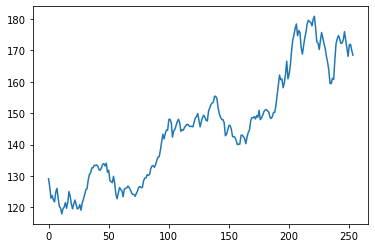

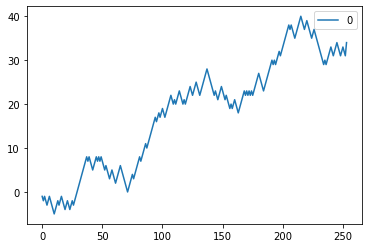

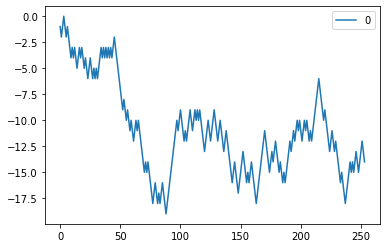

In [16]:
sample_avg.plot()
pd.DataFrame(y).plot()
pd.DataFrame(pred).plot()

S&P 500 Group Prediction

In [17]:
stocks_perf = {}
#for i in range (len(sp500_df.Name.unique())):
for i in range (3):
    ticker = sp500_df.Name.unique()[i] 
    time_frame = '3mo'
    acc_dict, pred, y, sample_avg = test_acc(data_processing_yf(ticker, time_frame))
    stocks_perf.update(acc_dict)

AAPL accuracy is 0.7258064516129032
MSFT accuracy is 0.5483870967741935
GOOG accuracy is 0.7096774193548387


In [18]:
stocks_perf

{'AAPL': 0.7258064516129032,
 'MSFT': 0.5483870967741935,
 'GOOG': 0.7096774193548387}

Stability Test

In [19]:
df_copy = sp500_df.copy(deep=True)
df_copy.head(2)

,Date,Open,Close,High,Low,Ratio1,Ratio2,Dividends,Volume,Name,trend_tmr_up
0,2020-02-19,78.915603,79.808334,80.042618,78.915603,0.396060,0.792120,0.0,93984000.0,AAPL,False
1,2020-02-20,79.564202,78.989594,80.062354,78.474177,0.505435,-0.361804,0.0,100566000.0,AAPL,False


In [20]:
def window_sliding (target_list, window_len, interval):
    ans = []
    num_loop = math.floor((len(target_list)-window_len)/interval)+1
    for i in range(num_loop):
        ans.append(target_list[i*interval:i*interval+window_len])
    return ans

In [51]:
ticker_list = sp500_df.Name.unique()[0:10]
time_frame = '1y'

In [50]:
sp500_df.Name.unique()[0:10]

array(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'FB', 'V',
       'JPM'], dtype=object)

In [54]:
def stability_performance_plot (ticker_list, time_frame):
    fig, axs = plt.subplots(len(ticker_list))
    fig.set_size_inches(18, 25)
    for i in range(len(ticker_list)):
        _, pred, y, _ = test_acc (data_processing_yf (ticker_list[i], time_frame))
        window_size = 30
        interval = 1
        pred_sliding = window_sliding(pred, window_size, interval)
        y_sliding = window_sliding(y, window_size, interval)
        pred_y = []
        for j in range (len(pred_sliding)):
            pred_y.append(pred_sliding[j]+y_sliding[j])
        acc_list =[]
        for z in range(len(pred_y)):
            acc_list.append(1-count_one(pred_y[z])/(len(pred_y[z])))
        axs[i].plot(acc_list)


AAPL accuracy is 0.6600790513833992
MSFT accuracy is 0.6284584980237153
GOOG accuracy is 0.6442687747035574
GOOGL accuracy is 0.691699604743083
AMZN accuracy is 0.7351778656126482
TSLA accuracy is 0.7035573122529644
NVDA accuracy is 0.7114624505928854
FB accuracy is 0.6600790513833992
V accuracy is 0.7272727272727273
JPM accuracy is 0.6521739130434783


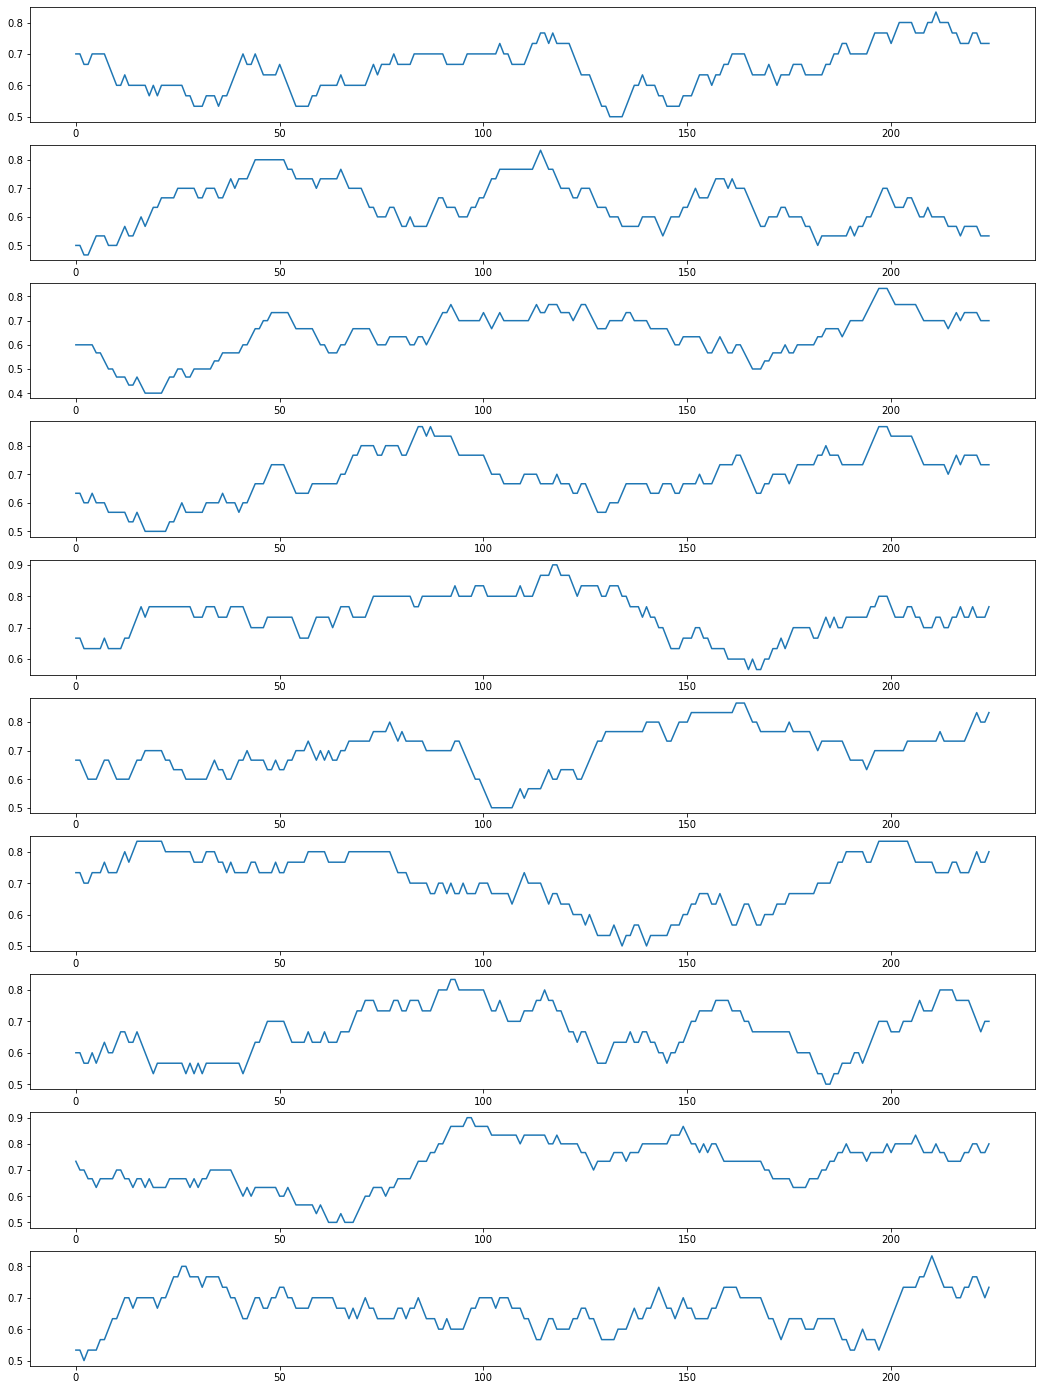

In [55]:
stability_performance_plot (ticker_list, time_frame)